In [246]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

env: THEANO_FLAGS=device=cpu,floatX=float32


# Data

In [247]:
def build_toy_dataset(N, K):
    pi = np.array([0.2, 0.5, 0.3])
    mus = [[1, 1], [-1, -1], [2,-2]]
    stds = [[0.1, 0.1], [0.1, 0.2], [0.2, 0.3]]
    x = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros((N,), dtype=np.int)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
        y[n] = k

    return x,y

N = 500  # number of data points
D = 2  # dimensionality of data

X, y = build_toy_dataset(N, 3)


In [248]:
X.shape

(500, 2)

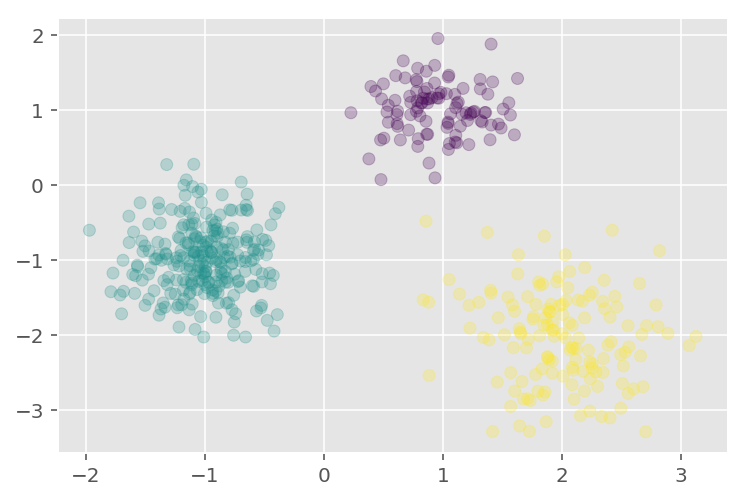

In [250]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, alpha=.25)

# Model

$p(x_n | \pi, \mu, \sigma) = \sum_{i=1}^K \pi_k \text{Normal}(x_n | \mu_k, \Sigma_k)$

$p(\pi) = \text{Dirichlet} (\pi | \alpha \mathbf{1}_k)$

$p(\mu_k) = \text{Normal}(0,I)$

$p(\Sigma_k ) = \text{LKJ} (\Sigma | \eta,sd) $

In [350]:
# set up model
K = 3
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    packed_chol = []
    chol = []
    for i in range(K):
        mu.append(pm.Normal('mu%i'%i, 0, 10, shape=2))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i,
                                             eta=2, 
                                             n=2, 
                                             sd_dist=pm.HalfNormal.dist(2.5)))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], chol=chol[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X)


In [361]:
model.basic_RVs

[pi_stickbreaking__,
 mu0,
 chol_cov_0_cholesky-cov-packed__,
 mu1,
 chol_cov_1_cholesky-cov-packed__,
 mu2,
 chol_cov_2_cholesky-cov-packed__,
 x_obs]

# Inference

## NUTS

In [341]:
with model:
    trace = pm.sample(1000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [chol_cov_2, mu2, chol_cov_1, mu1, chol_cov_0, mu0, pi]
100%|██████████| 2000/2000 [03:10<00:00, 10.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## FullRankADVI via pm.FullRankADVI()

In [253]:
with model:
    advi_fr=pm.FullRankADVI()
    advi_fr.fit(50000)

Average Loss = 1,210.8: 100%|██████████| 50000/50000 [03:23<00:00, 246.28it/s]
Finished [100%]: Average Loss = 1,210.8


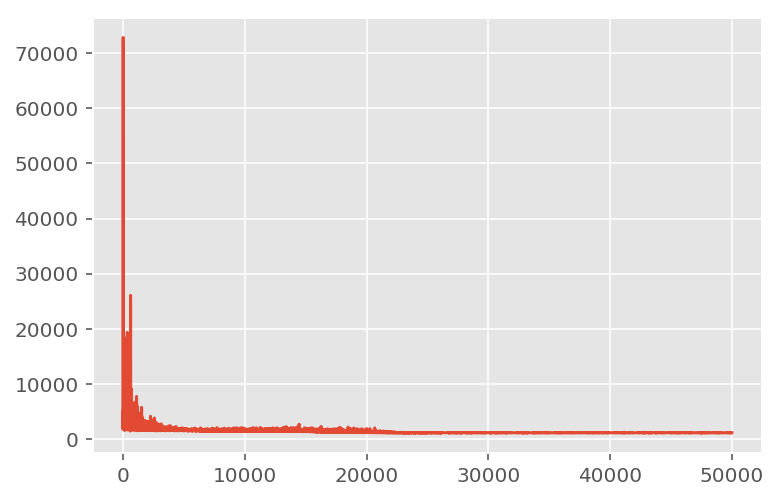

In [255]:
plt.plot(advi_fr.hist);

## FullRankADVI via pm.fit()

In [261]:
with model:
    advi_fr2 = pm.fit(n=50000, method='fullrank_advi', obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 1,321.5: 100%|██████████| 50000/50000 [02:52<00:00, 289.66it/s]
Finished [100%]: Average Loss = 1,321.4


In [262]:
with model:
    advi_fr3 = pm.fit(n=50000, method='fullrank_advi')

Average Loss = 1,078.9: 100%|██████████| 50000/50000 [02:53<00:00, 287.45it/s]
Finished [100%]: Average Loss = 1,078.9


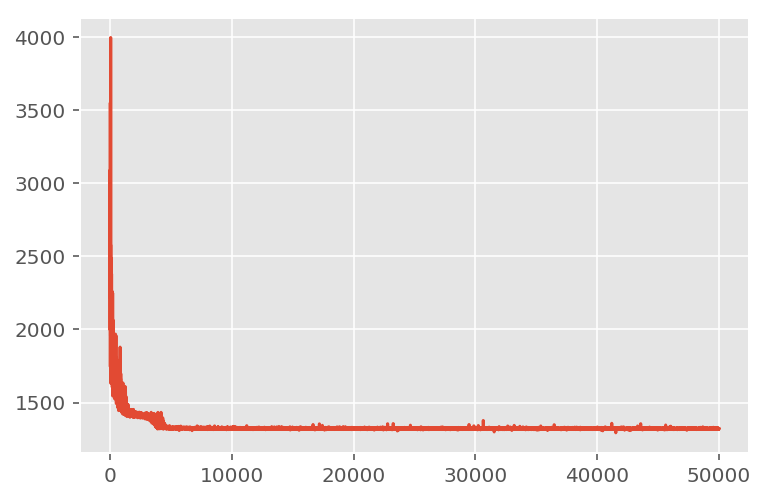

In [263]:
plt.plot(advi_fr2.hist);

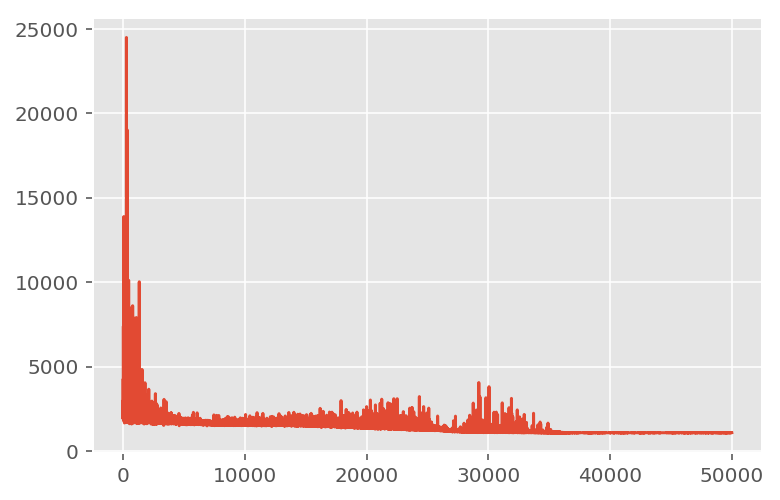

In [264]:
plt.plot(advi_fr3.hist)

## ADVI via pm.ADVI()

In [265]:
with model:
    advi_mf=pm.ADVI()
    advi_mf.fit(50000)

Average Loss = 1,078.5: 100%|██████████| 50000/50000 [02:54<00:00, 287.23it/s]
Finished [100%]: Average Loss = 1,078.5


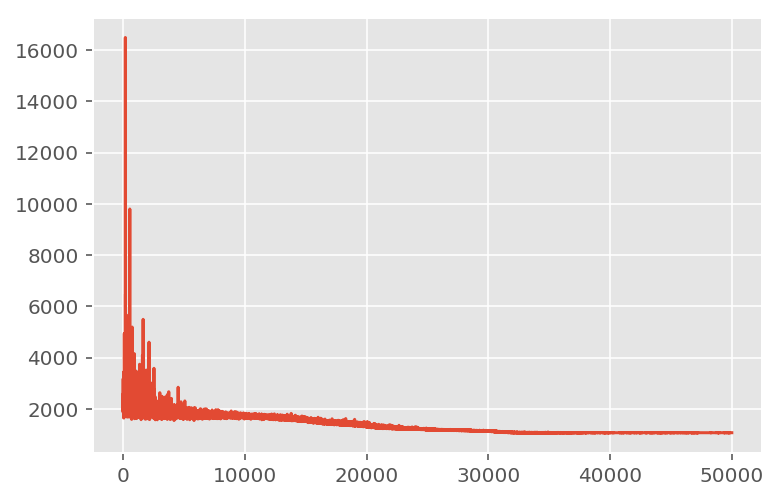

In [268]:
plt.plot(advi_mf.hist);

## ADVI via pm.fit()

In [266]:
with model:
    advi_mf2 = pm.fit(n=50000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 1,078.3: 100%|██████████| 50000/50000 [02:44<00:00, 327.53it/s]
Finished [100%]: Average Loss = 1,078.3


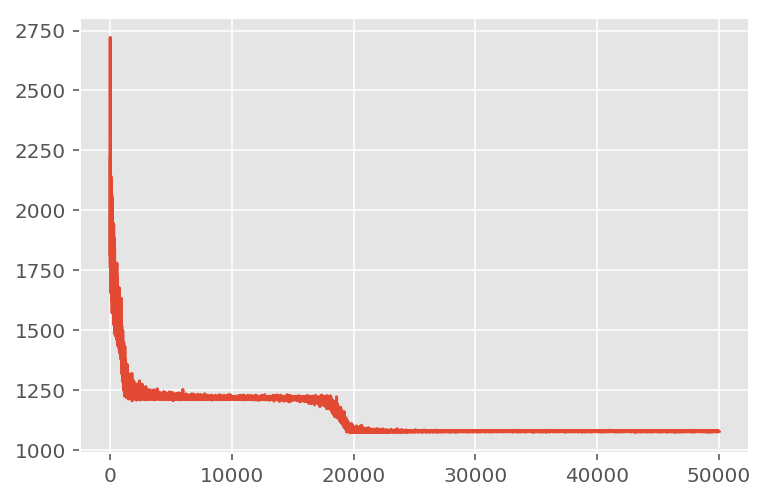

In [269]:
plt.plot(advi_mf2.hist);

# Criticism

## PDI

based on paper http://proceedings.mlr.press/v70/kucukelbir17a/kucukelbir17a.pdf

In [645]:
from pymc3.stats import _log_post_trace
def PDI_local(trace, model):
    log_px = _log_post_trace(trace, model) # shape (nsamples, N_datapoints)
    
    # log posterior predictive density of data point n = E_{q(\theta)} p(x_n|\theta) 
    lppd_n = sp_logsumexp(log_px, axis=0, b=1.0 / log_px.shape[0])
    
    mu_n = np.exp(lppd_n)
    
    var_log_n = np.var(log_px, axis=0)
    
    mu_log_n = np.mean(log_px, axis=0)
    
    var_n = np.var(np.exp(log_px), axis=0)
    
    pdi = np.divide(var_n, mu_n)
    pdi_log = np.divide(var_log_n, mu_log_n)
    
    wapdi = np.divide(var_log_n, np.log(mu_n))
    
    return pdi, pdi_log, wapdi

# PSIS
based on https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Comparing%20VI%20approximation.ipynb

In [272]:
#PSIS
from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

def log_important_ratio(approx, nsample):
    logp_func = approx.model.logp

    # in ADVI there are only 1 group approximation
    approx_group = approx.groups[0]
    if approx.short_name == "mean_field":
        mu_q = approx_group.params[0].eval()
        std_q = rho2sd(approx_group.params[1]).eval()
        logq_func = st.norm(mu_q, std_q)
    elif approx.short_name == "full_rank":
        packed_chol_q = approx_group.params[0]
        mu_q = approx_group.params[1].eval()
        dim = mu_q.shape[0]
        chol_q = pm.expand_packed_triangular(dim, packed_chol_q, lower=True).eval()
        cov_q = np.dot(chol_q, chol_q.T)
        logq_func = st.multivariate_normal(mu_q, cov_q)
        
    dict_to_array = approx_group.bij.map

    p_theta_y = []
    q_theta = []
    samples = approx.sample_dict_fn(nsample)  # type: dict
    points = ({name: records[i] for name, records in samples.items()}
              for i in range(nsample))

    for point in points:
        p_theta_y.append(logp_func(point))
        q_theta.append(np.sum(logq_func.logpdf(dict_to_array(point))))
    p_theta_y = np.asarray(p_theta_y)
    q_theta = np.asarray(q_theta)
    return p_theta_y-q_theta


In [292]:
nsample = 10000
ratio_advi_mf = log_important_ratio(advi_mf.approx, nsample)
_, k = pm.stats._psislw(ratio_advi_mf[:, None], 1)
k

array([0.18124148])

In [293]:
ratio_advi_mf2 = log_important_ratio(advi_mf2, nsample)
_, k2 = pm.stats._psislw(ratio_advi_mf2[:, None], 1)
k2

array([0.29834955])

In [294]:
ratio_advi_fr = log_important_ratio(advi_fr.approx, nsample)
_, k_fr = pm.stats._psislw(ratio_advi_fr[:, None], 1)
k_fr

array([1.08191354])

In [564]:
ratio_advi_fr2 = log_important_ratio(advi_fr2, nsample)
_, k_fr2 = pm.stats._psislw(ratio_advi_fr2[:, None], 1)
k_fr2

array([1.35211575])

# Prediction

In [307]:
complogp = xobs.distribution._comp_logp(theano.shared(X))
f_complogp = model.model.fastfn(complogp)

In [595]:
def predict_cluster(approx, nsample, X):
    complogp = xobs.distribution._comp_logp(theano.shared(X))
    f_complogp = model.model.fastfn(complogp)
    trace = approx.sample(nsample)
    
    point = model.test_point
    for i in np.arange(K):
        point['mu%i'%i] = np.mean(trace['mu%i'%i], axis=0) # take average over samples
        chollabel = 'chol_cov_%i_cholesky-cov-packed__'%i
        point[chollabel] = np.mean(trace[chollabel], axis=0) # take average over samples
        
    y = np.argmax(f_complogp(point), axis=1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, alpha=0.25)
    plt.title(approx.short_name + " with {0:d} cluster".format(K))
    return y
    

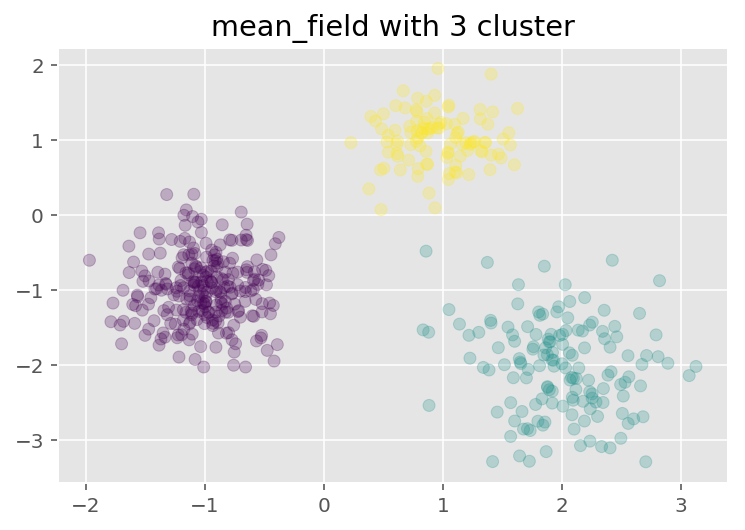

In [336]:
advi_mf_y = predict_cluster(advi_mf.approx, 1000)

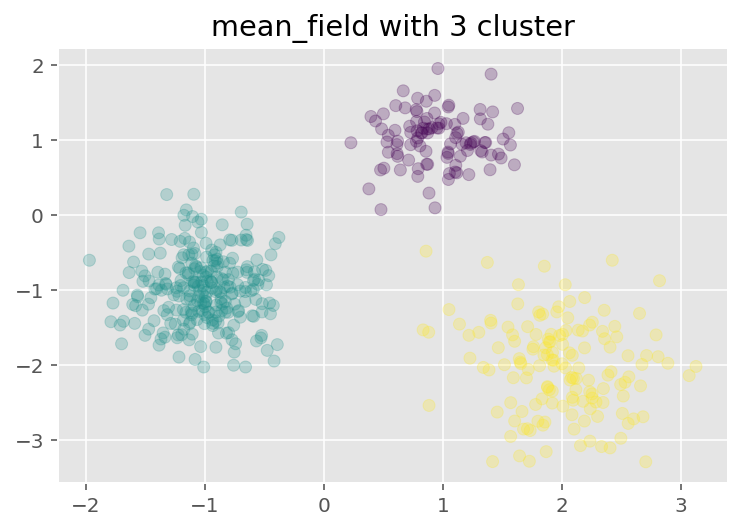

In [542]:
advi_mf2_y = predict_cluster(advi_mf2, 1000)

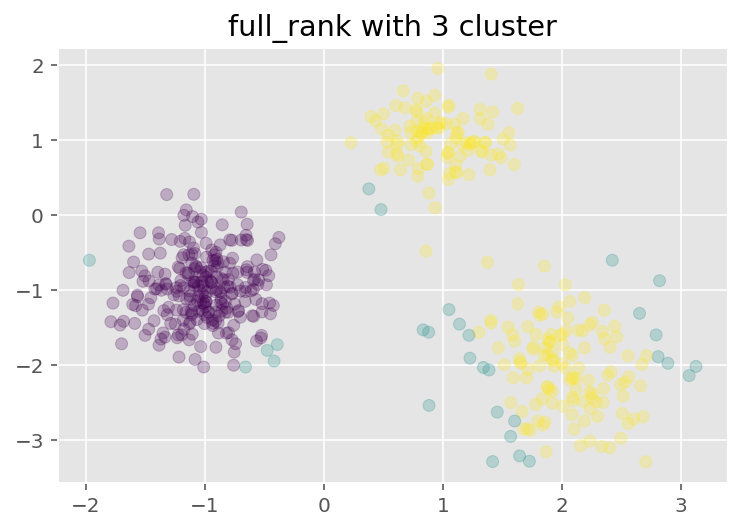

In [338]:
advi_fr_y = predict_cluster(advi_fr.approx, 1000)

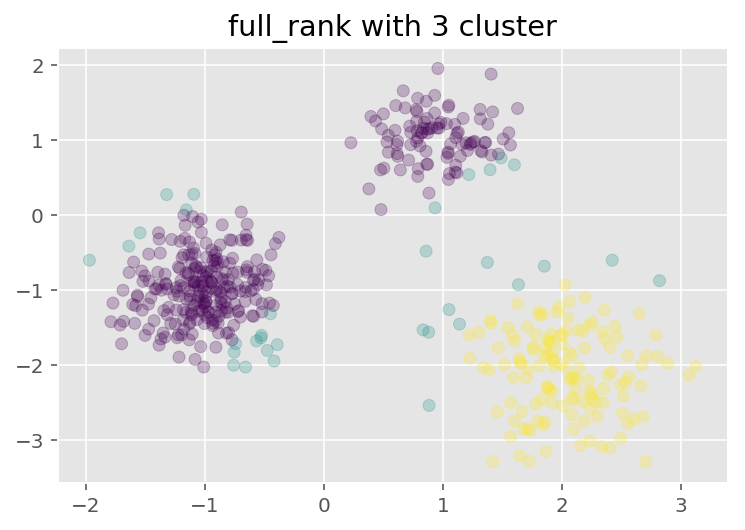

In [339]:
advi_fr2_y = predict_cluster(advi_fr2, 1000)

From the plot above, we could find that `FullRankADVI` only identifies two clusters. The prediction performance is consistent with the result of PSIS diagnosis.

One possible explanation why `FullRankADVI` has mode collapse:


    For mean-field Gaussian you’re approximating family is a product of Gaussians on the two axes, which, for example, can’t approximate a narrow Gaussian concentrated around the line y=x.

    For the full rank one, I’d expect it to be in the correct place, but the covariance matrix to be too “concentrated”. This is because the KL divergence is an asymmetric measure of “distance” between two probability distributions and in the direction that it is used for VI, it penalises approximations that are too diffuse far more fiercely than approximations that are too concentrated. This leads to a systematic underestimation of variation using VB methods.

Quote from https://discourse.mc-stan.org/t/correlated-2d-gaussian-breaks-advi/2055/3?u=junpenglao

Now, let's check the prediction of baseline NUTS.

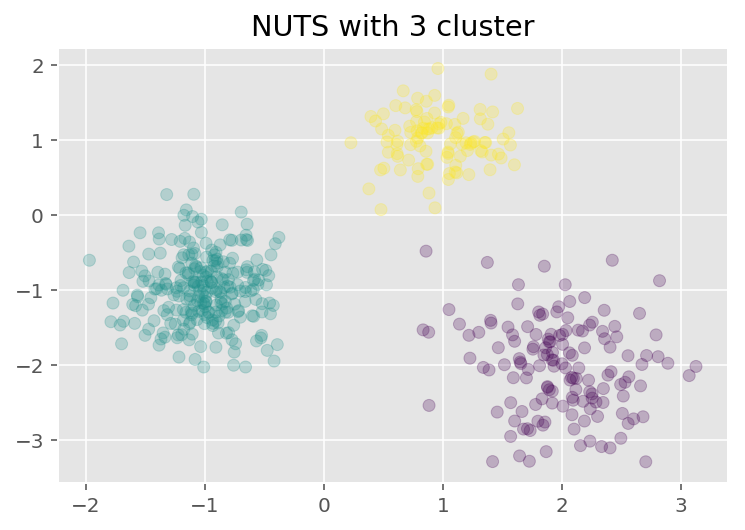

In [344]:
trace = approx.sample(nsample)
for i in np.arange(K):
    point['mu%i'%i] = np.mean(trace['mu%i'%i], axis=0) # take average over samples
    chollabel = 'chol_cov_%i_cholesky-cov-packed__'%i
    point[chollabel] = np.mean(trace[chollabel], axis=0) # take average over samples
        
nuts_y = np.argmax(f_complogp(point), axis=1)
plt.scatter(X[:, 0], X[:, 1], c=nuts_y, cmap=plt.cm.viridis, alpha=0.25)
plt.title("NUTS with {0:d} cluster".format(K));

In [371]:
# test utils
from utils import PSIS
test_k = PSIS(advi_mf.approx, 10000)

In [372]:
test_k

array([0.14607049])

# ADVI with minibatch

In [543]:
N_new = 10000  # number of data points
D = 2  # dimensionality of data

X_new, y_new = build_toy_dataset(N_new, 3)

In [544]:
X_new.shape

(10000, 2)

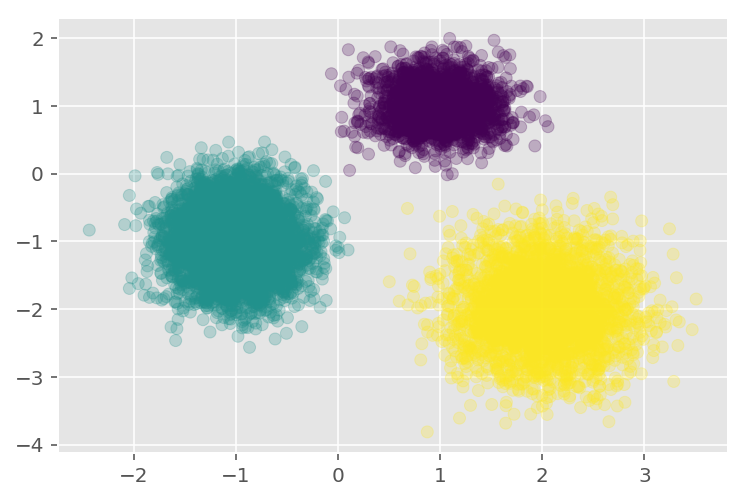

In [545]:
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, cmap=plt.cm.viridis, alpha=.25);

In [569]:
X_shared = theano.shared(X_new)

minibatch_size = 200
X_minibatch = pm.Minibatch(X_new, minibatch_size)

In [570]:
# set up model
K = 3
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    packed_chol = []
    chol = []
    for i in range(K):
        mu.append(pm.Normal('mu%i'%i, 0, 10, shape=2))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i,
                                             eta=2, 
                                             n=2, 
                                             sd_dist=pm.HalfNormal.dist(2.5)))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], chol=chol[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X_shared)


In [571]:
with model:
    advi_mf=pm.ADVI()
    advi_mf.fit(10000, more_replacements={X_shared: X_minibatch},
                obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 464: 100%|██████████| 10000/10000 [00:32<00:00, 308.79it/s]  
Finished [100%]: Average Loss = 464.07


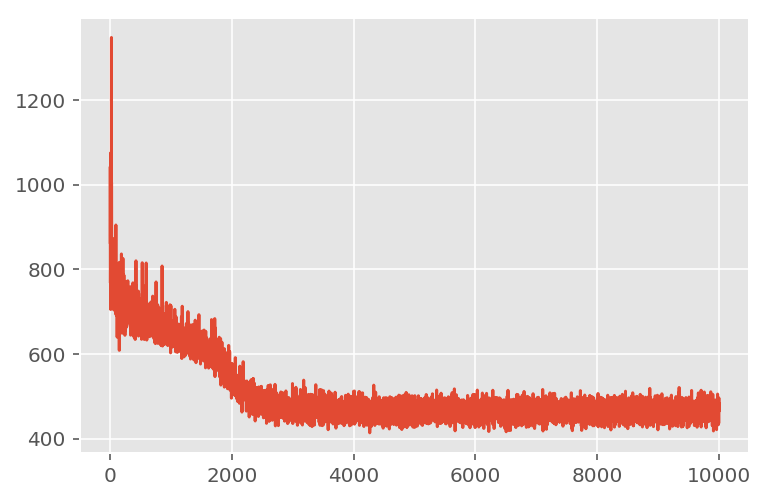

In [572]:
plt.plot(advi_mf.hist);

If ADVI has not converged, we could run approximation longer.

In [573]:
advi_mf.refine(20000)

Average Loss = 463.53: 100%|██████████| 20000/20000 [01:09<00:00, 286.49it/s]
Finished [100%]: Average Loss = 463.5


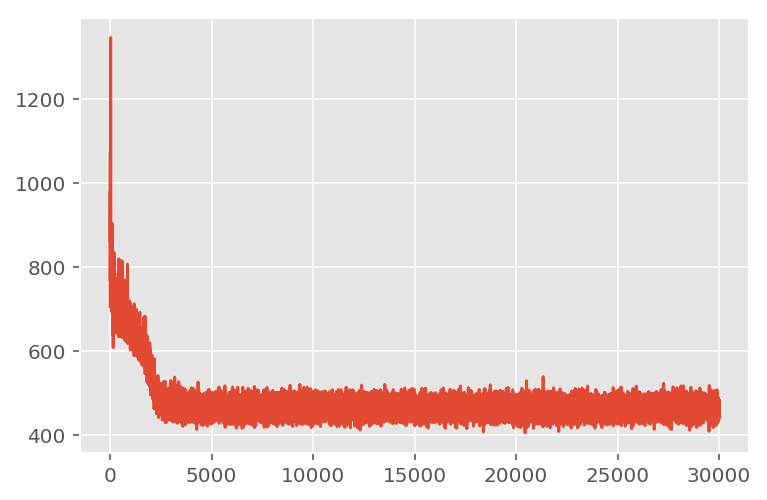

In [574]:
plt.plot(advi_mf.hist);

In [575]:
#posterior inference
approx = advi_mf.approx
means = approx.bij.rmap(approx.mean.eval())
sds = approx.bij.rmap(approx.std.eval())

(-6, 6)

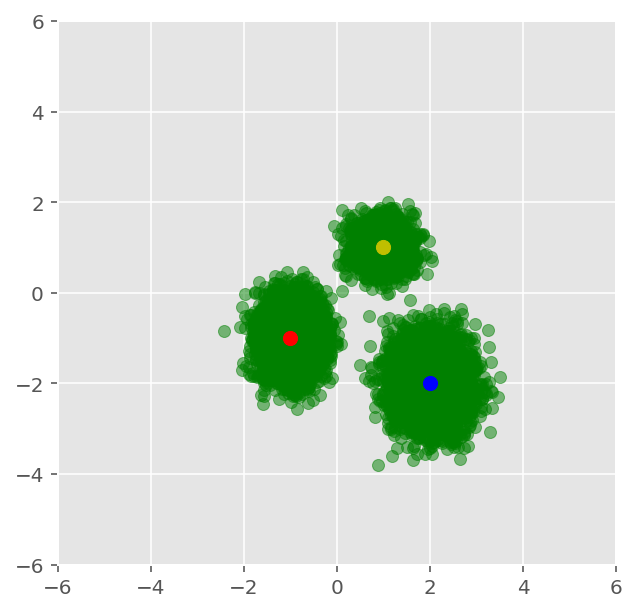

In [576]:
from copy import deepcopy

mu_0, sd_0 = means['mu0'], sds['mu0']
mu_1, sd_1 = means['mu1'], sds['mu1']
mu_2, sd_2 = means['mu2'], sds['mu2']

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.5, c='g')
plt.scatter(mu_0[0], mu_0[1], c="r", s=50)
plt.scatter(mu_1[0], mu_1[1], c="b", s=50)
plt.scatter(mu_2[0], mu_2[1], c="y", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [577]:
post_samples = approx.sample(100)

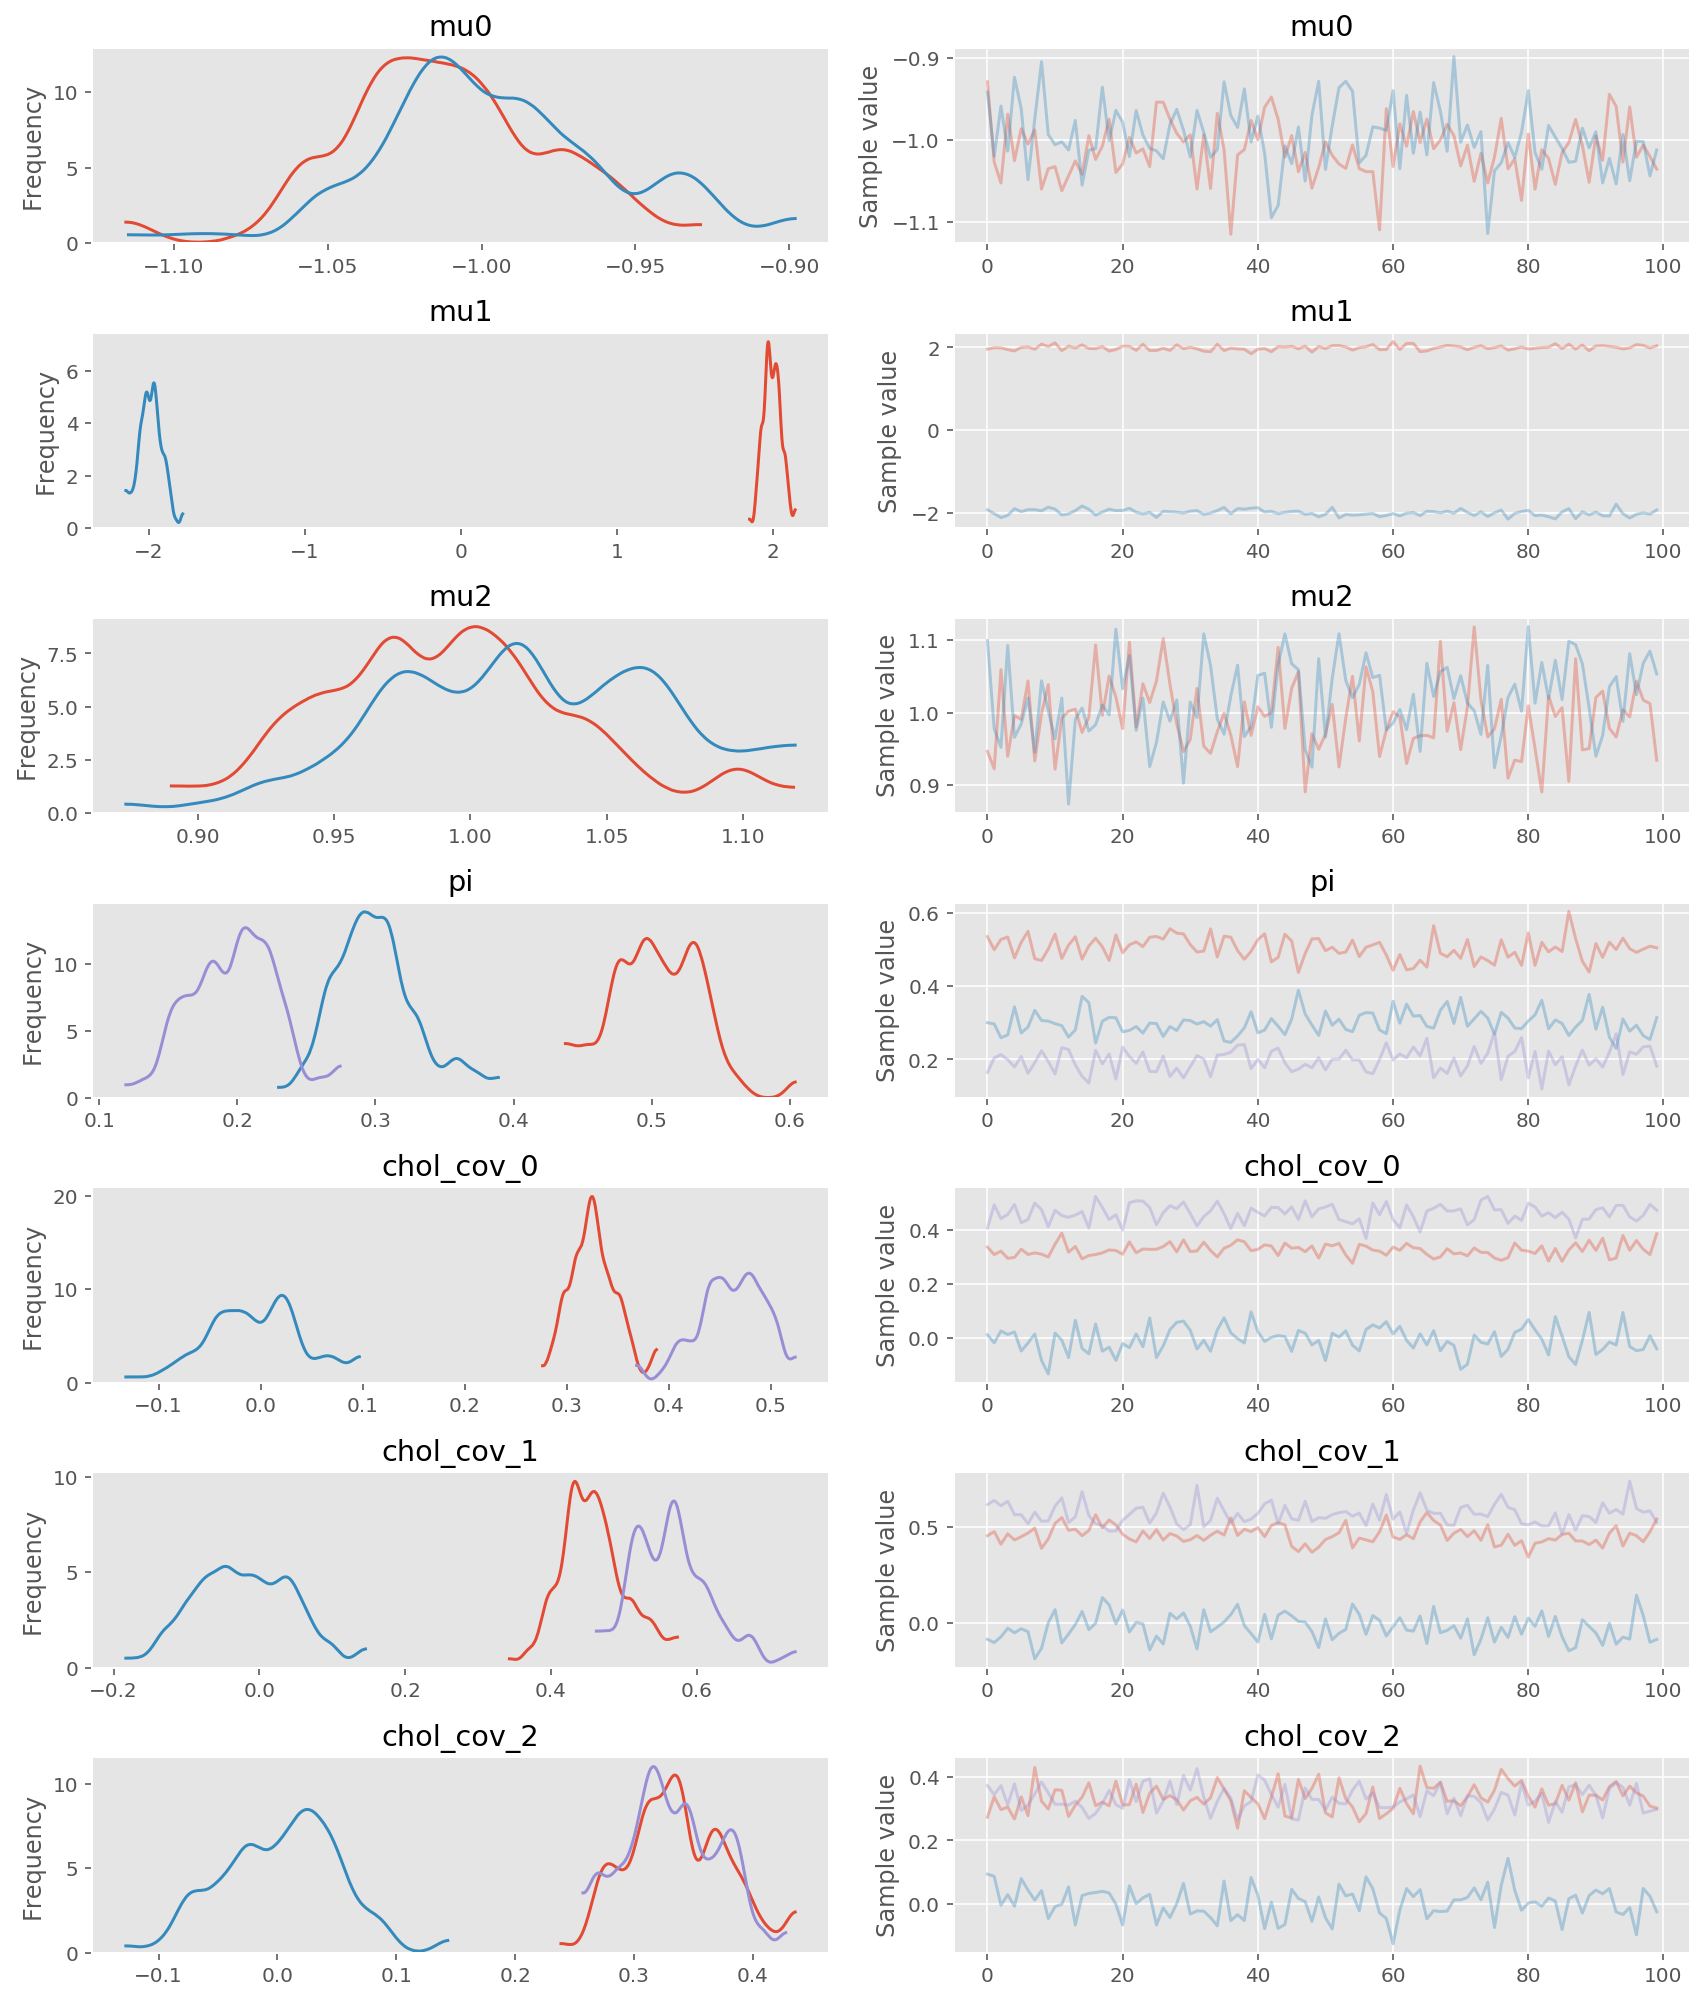

In [578]:
pm.traceplot(post_samples);

In [579]:
post_samples['mu0'].mean(axis=0)

array([-1.0124562 , -0.99606824], dtype=float32)

In [580]:
mu_0

array([-1.0102098, -1.0037948], dtype=float32)

In [581]:
mu_1

array([ 1.998051 , -1.9932344], dtype=float32)

In [582]:
mu_2

array([0.9922092, 1.0050594], dtype=float32)

array([1, 2, 2, ..., 0, 0, 2])

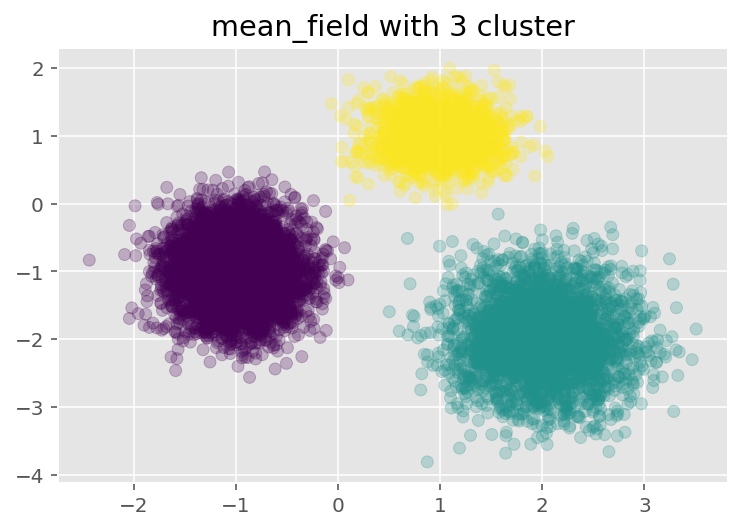

In [589]:
predict_cluster(advi_mf.approx, 1000, X_new)

Now it seems good.

# Diagnosis

In [583]:
# PSIS
test_k = PSIS(advi_mf.approx, 10000)

In [584]:
test_k

array([21.38853134])

In [641]:
# PDI
from utils import PDI
pdi, pdi_log, wapdi = PDI(post_samples, model)

In [642]:
pdi.shape

(10000,)

In [637]:
pdi_log.shape

(10000,)

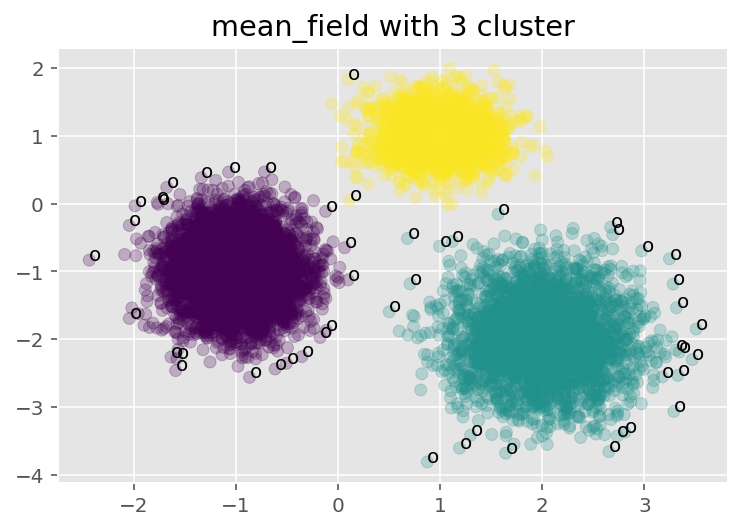

In [660]:
num_top_pdis = 50
largest_pdis = pdi1.argsort()[0:num_top_pdis]

y = predict_cluster(advi_mf.approx, 1000, X_new)

for i in range(num_top_pdis): 
    plt.text(X_new[largest_pdis[i]][0],X_new[largest_pdis[i]][1] , "o", fontsize=10)


Since pdi-log is negative. Outliers should have large |pdi-log| value, which is small |pdi-log| value.

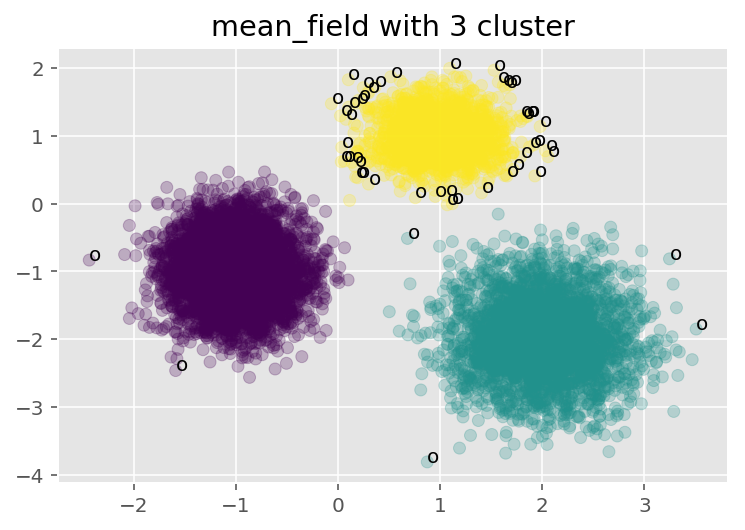

In [661]:
num_top_pdilogs = 50
largest_pdilogs = pdi2.argsort()[0:num_top_pdilogs]

y = predict_cluster(advi_mf.approx, 1000, X_new)

for i in range(num_top_pdilogs): 
    plt.text(X_new[largest_pdilogs[i]][0],X_new[largest_pdilogs[i]][1] , "o", fontsize=10)


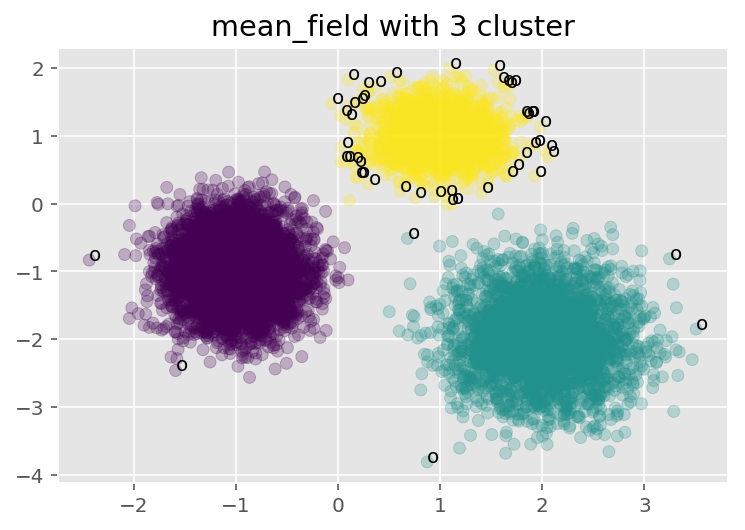

In [662]:
num_top_wapdis = 50
largest_wapdis = wapdi.argsort()[0:num_top_wapdis]

y = predict_cluster(advi_mf.approx, 1000, X_new)

for i in range(num_top_pdilogs): 
    plt.text(X_new[largest_wapdis[i]][0],X_new[largest_wapdis[i]][1] , "o", fontsize=10)


In [614]:
point = model.test_point

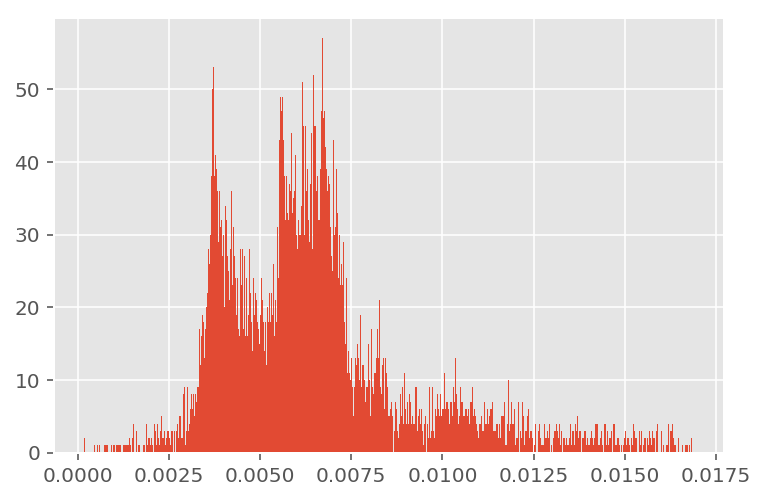

In [632]:
plt.hist(pdi, bins=1000);

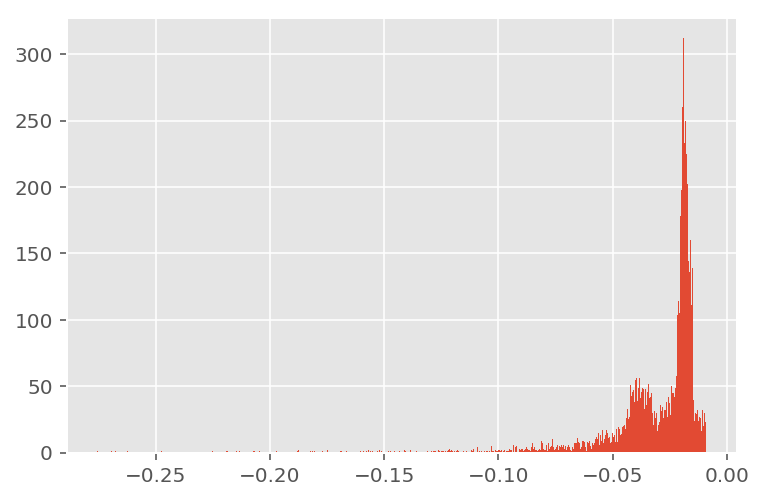

In [633]:
plt.hist(pdi_log, bins=1000);

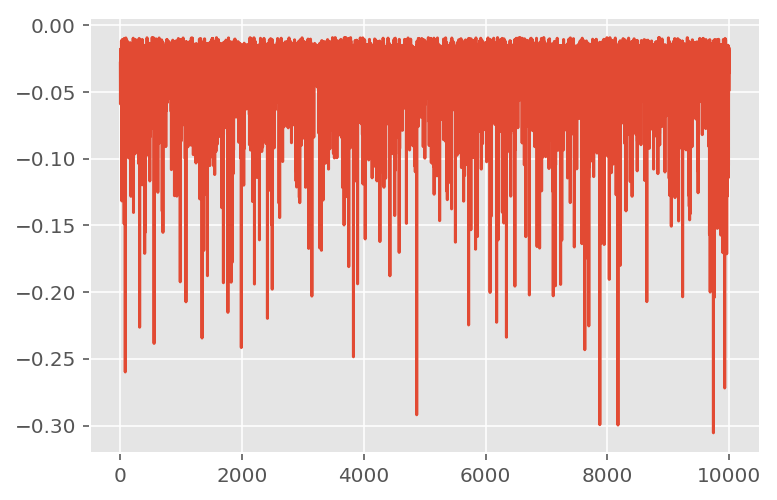

In [648]:
plt.plot(wapdi)

In [644]:
wapdi

array([1.57886844, 0.27126486, 1.84731177, ..., 0.03084593, 0.11077719,
       0.30949584])

In [646]:
pdi1, pdi2, wapdi = PDI_local(post_samples, model)